In [18]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [19]:
%matplotlib inline

import itertools
#from sessions import selected_009266, selected_008229, selected_009265, selected_57, selected_013829
from sessions_nMAP_EV_SU import selected
from imports import *
from scipy import stats
from scipy import signal
from skimage.segmentation import watershed, slic
from Behavior.behavior import get_extent, get_idxs_behav_state, get_idxs_in_patches
from Behavior.behavior import density_map, density_map, get_idxs_neuro_state
from matplotlib.lines import Line2D

from sklearn import decomposition
#from population import unit_activity_matrix
from psth import get_psth_matrix

In [20]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [21]:
def pval2text(p_val):
    if p_val > 0.05:
        return 'n.s.'
    elif p_val > 0.01:
        return '*'
    elif p_val > 0.001:
        return '**'
    elif p_val > 0.01:
        return '***'
    else:
        return '****'

In [23]:
source = '/home/sobolev/nevermind_ag-grothe/AG_Pecka/data/processed/'
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
rep_path = '/home/sobolev/nevermind/Andrey/analysis/manuscripts/'

all_selected = []
for animal, s_list in selected.items():
    all_selected += s_list
all_selected[:5]

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39']

## Single session - neural manifold

In [29]:
session = all_selected[0]

animal   = session.split('_')[0]
session_path = os.path.join(source, animal, session)
#nmap_file  = os.path.join(session_path, 'analysis', 'nMAP_EV_SU_noconv.h5')
nmap_file  = os.path.join(session_path, 'analysis', 'nMAP_EV_SU_with_PSTH.h5')
bmap_file  = os.path.join(session_path, 'analysis', 'bMAP_segmentation.h5')
meta_file  = os.path.join(session_path, 'meta.h5')
desc_file  = os.path.join(session_path, 'descendants.h5')

with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    sound_events = np.array(f['processed']['sound_events'])
    tgt_mx = np.array(f['processed']['target_matrix'])
with h5py.File(nmap_file, 'r') as f:
    response_manifold = np.array(f['response_manifold'])
    unit_mx_ev = np.array(f['unit_mx_proc_ev'])
    unit_mx_su = np.array(f['unit_mx_proc_su'])
    
#if os.path.exists(desc_file):
with h5py.File(desc_file, 'r') as f:
    speed = np.array(f['speed'])
    hd    = np.array(f['hd'])
# else:
#     speed = tl[:, 3]
#     hd    = tl[:, 4]
    
with h5py.File(bmap_file, 'r') as f:
    idxs_tgt_succ_state_ev = np.array(f['idxs_tgt_succ_state_ev'])
idxs_bU_ev = np.array([x for x in range(len(sound_events)) if not x in idxs_tgt_succ_state_ev])

fit = response_manifold  # short var name
response_manifold.shape, session

((9599, 2), '009266_hippoSIT_2023-04-17_17-04-17')

In [30]:
unit_mx_ev.shape, unit_mx_su.shape  # event sampling

((9599, 16), (9599, 16))

In [31]:
# compute event indices
speed_thresh = 0.04  # m/s

idxs_suc_ev = []
for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
    idxs_suc_ev += list(np.arange(tgt_rec[0], tgt_rec[1] + 1))
idxs_suc_ev = np.array(idxs_suc_ev)

# auditory state (BGR, SIL etc.) and speed filter
idxs_sta_ev = np.where(speed[sound_events[:, 2].astype(np.int32)] < speed_thresh)[0]  # define speed filter here
idxs_run_ev = np.where(speed[sound_events[:, 2].astype(np.int32)] > speed_thresh)[0]
idxs_bgr_ev = np.where(sound_events[:, 1] == 1)[0]
idxs_sil_ev = np.where(sound_events[:, 1] == 0)[0]
idxs_tgt_ev = np.where(sound_events[:, 1] == 2)[0]
idxs_noi_ev = np.where(sound_events[:, 1] == -1)[0]
idxs_non_ev = np.where( (sound_events[:, 1] == 0) | (sound_events[:, 1] == 1) )[0]  # non-target

# for behavioral state
idxs_non_sta_ev    = np.intersect1d(idxs_sta_ev, idxs_non_ev)
idxs_non_sta_bE_ev = np.intersect1d(idxs_tgt_succ_state_ev, idxs_non_sta_ev)
idxs_non_sta_bU_ev = np.intersect1d(idxs_bU_ev, idxs_non_sta_ev)
idxs_sil_sta_ev    = np.intersect1d(idxs_sta_ev, idxs_sil_ev)

# for speed
idxs_non_run_ev    = np.intersect1d(idxs_run_ev, idxs_non_ev)
idxs_non_run_bU_ev = np.intersect1d(idxs_bU_ev, idxs_non_run_ev)
idxs_sil_bU_ev     = np.intersect1d(idxs_bU_ev, idxs_sil_ev)

### Sound events

/tmp/ipykernel_509432/3196492861.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


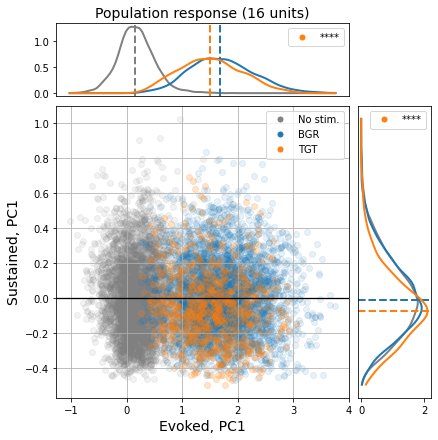

In [32]:
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(6.5, 6.5))
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4), left=0.1, right=0.9, \
                      bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

idxs_all = [idxs_sil_ev, idxs_bgr_ev, idxs_suc_ev]  # can be also all TGT, idxs_tgt_ev
colors   = ['gray', 'tab:blue', 'tab:orange']
alphas   = [0.1, 0.1, 0.2]
labels   = ['No stim.', 'BGR', 'TGT']

# first - scatter plots
legend_elements = [
    Line2D([0], [0], marker='.', linestyle='None', color='grey', markersize=10, label='No stim.'),
    Line2D([0], [0], marker='.', linestyle='None', color='tab:blue', markersize=10, label='BGR'),
    Line2D([0], [0], marker='.', linestyle='None', color='tab:orange', markersize=10, label='TGT'),
]

ax = fig.add_subplot(gs[1, 0])
for i, idxs in enumerate(idxs_all):
    ax.scatter(fit[idxs][:, 0], fit[idxs][:, 1], alpha=alphas[i], color=colors[i], label=labels[i])
#ax.scatter(fit[:, 0], fit[:, 1], alpha=0.1, c=np.log(speed[sound_events[:, 2].astype(np.int32)]), cmap='seismic')

# regression line for no stimulus
res = stats.linregress(fit[idxs_sil_ev][:, 0], fit[idxs_sil_ev][:, 1])
x = np.array([fit[idxs_sil_ev][:, 0].min(), 1])
#ax.plot(x, res.intercept + res.slope*x, color='black', alpha=0.8, ls='--')

ax.set_xlabel('Evoked, PC1', fontsize=14)
ax.set_ylabel('Sustained, PC1', fontsize=14)
ax.legend(handles=legend_elements)
ax.axhline(0, color='black', lw=1.3)
#ax.axvline(0, color='black', lw=1.3)
ax.grid()


# second - evoked histograms
x = np.linspace(fit[:, 0].min(), fit[:, 0].max(), 100)

p_val = stats.mannwhitneyu(fit[idxs_bgr_ev][:, 0], fit[idxs_suc_ev][:, 0]).pvalue
legend_elements = [
    Line2D([0], [0], marker='.', linestyle='None', color='tab:orange', markersize=10, label='%s' % pval2text(p_val)),
]

ax = fig.add_subplot(gs[0, 0])
for i, idxs in enumerate(idxs_all):
    density = stats.kde.gaussian_kde(fit[idxs][:, 0])
    ax.plot(x, density(x), color=colors[i], lw=2)
    ax.axvline(np.median(fit[idxs][:, 0]), ls='--', color=colors[i], lw=2)
ax.set_xticks([])
ax.legend(handles=legend_elements)
ax.set_title('Population response (%d units)' % unit_mx_ev.shape[1], fontsize=14)

# third - sustained histograms
y = np.linspace(fit[:, 1].min(), fit[:, 1].max(), 100)

p_val = stats.mannwhitneyu(fit[idxs_bgr_ev][:, 1], fit[idxs_suc_ev][:, 1]).pvalue
legend_elements = [
    Line2D([0], [0], marker='.', linestyle='None', color='tab:orange', markersize=10, label='%s' % pval2text(p_val)),
]

ax = fig.add_subplot(gs[1, 1])
for i, idxs in enumerate(idxs_all):
    density = stats.kde.gaussian_kde(fit[idxs][:, 1])
    ax.plot(density(y), y, color=colors[i], lw=2)
    ax.axhline(np.median(fit[idxs][:, 1]), ls='--', color=colors[i], lw=2)
ax.legend(handles=legend_elements)
ax.set_yticks([])

fig.tight_layout()
#fig.savefig(os.path.join(rep_path, '%s_EV_SU_sound_state_map.png' % session[-19:-6]), dpi=300)

## For manuscript: example evoked / sustained matrices and responses

In [40]:
x_l, x_r = 0, 12  # in seconds

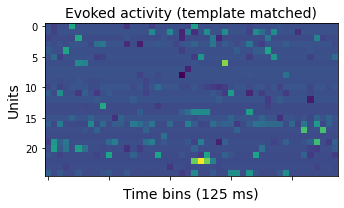

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

ax.imshow(unit_mx_ev[x_l*4:x_r*4].T)
ax.set_xlabel('Time bins (125 ms)', fontsize=14)
ax.set_title('Evoked activity (template matched)', fontsize=14)
ax.set_xticklabels([])
ax.set_ylabel('Units', fontsize=14)

fig.tight_layout()
fig.savefig(os.path.join(rep_path, '%s_evoked_mx.png' % session[-19:-6]), dpi=300)

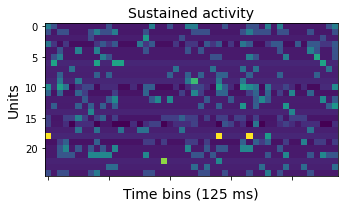

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

ax.imshow(unit_mx_su[x_l*4:x_r*4].T)
ax.set_xlabel('Time bins (125 ms)', fontsize=14)
ax.set_title('Sustained activity', fontsize=14)
ax.set_xticklabels([])
ax.set_ylabel('Units', fontsize=14)

fig.tight_layout()
fig.savefig(os.path.join(rep_path, '%s_sustained_mx.png' % session[-19:-6]), dpi=300)

In [48]:
x_l, x_r = 0, 6
idxs_p = np.where((sound_events[:, 0] > x_l) & (sound_events[:, 0] < x_r))[0]

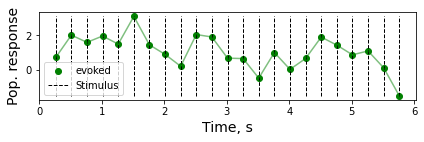

In [47]:
# selected for the manuscript
fig, ax = plt.subplots(1, 1, figsize=(6, 2))

#evoked_act = response_manifold[:, 0]
evoked_act = unit_mx_ev.sum(axis=1)/unit_mx_ev.shape[1]
idxs_p = np.where((sound_events[:, 0] > x_l) & (sound_events[:, 0] < x_r))[0]

ax.plot(sound_events[idxs_p][:, 0], evoked_act[idxs_p], color='green', alpha=0.5, lw=1.5)
ax.scatter(sound_events[idxs_p][:, 0], evoked_act[idxs_p], color='green', label='evoked')
ax.vlines(sound_events[idxs_p][:, 0], evoked_act[idxs_p].min(), evoked_act[idxs_p].max(), color='black', lw=1, ls='--', label='Stimulus')

ax.set_xlabel('Time, s', fontsize=14)
ax.set_ylabel('Pop. response', fontsize=14)
ax.legend()

fig.tight_layout()
fig.savefig(os.path.join(rep_path, '%s_evoked_response.png' % session[-19:-6]), dpi=300)

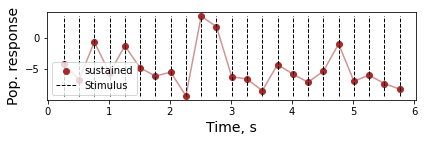

In [52]:
# selected for the manuscript
fig, ax = plt.subplots(1, 1, figsize=(6, 2))


su_pca = decomposition.PCA(n_components=2)
su_X   = su_pca.fit_transform(unit_mx_ev)
su_resp = su_X[:, 0]  # PC1 scores. bin_size resolution

ax.plot(sound_events[idxs_p][:, 0], su_resp[idxs_p], color='brown', alpha=0.5, lw=1.5)
ax.scatter(sound_events[idxs_p][:, 0], su_resp[idxs_p], color='brown', label='sustained')
ax.vlines(sound_events[idxs_p][:, 0], su_resp[idxs_p].min(), su_resp[idxs_p].max(), color='black', lw=1, ls='--', label='Stimulus')

ax.set_xlabel('Time, s', fontsize=14)
ax.set_ylabel('Pop. response', fontsize=14)
ax.legend(loc='lower left')

fig.tight_layout()
fig.savefig(os.path.join(rep_path, '%s_sustained_response.png' % session[-19:-6]), dpi=300)

### Behavioral state

/tmp/ipykernel_229220/1664856836.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


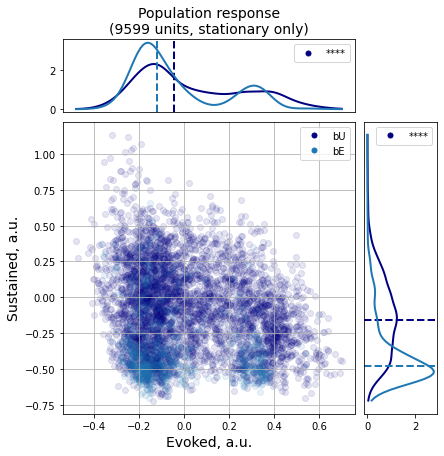

In [124]:
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(6.5, 6.5))
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4), left=0.1, right=0.9, \
                      bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

idxs_all = [idxs_non_sta_bU_ev, idxs_non_sta_bE_ev]  # can be also all TGT, idxs_tgt_ev
colors   = ['navy', 'tab:blue']
alphas   = [0.1, 0.1]
labels   = ['bU', 'bE']

# first - scatter plots
legend_elements = [
    Line2D([0], [0], marker='.', linestyle='None', color=colors[0], markersize=10, label=labels[0]),
    Line2D([0], [0], marker='.', linestyle='None', color=colors[1], markersize=10, label=labels[1]),
]

ax = fig.add_subplot(gs[1, 0])
for i, idxs in enumerate(idxs_all):
    ax.scatter(fit[idxs][:, 0], fit[idxs][:, 1], alpha=alphas[i], color=colors[i], label=labels[i])
#ax.scatter(fit[:, 0], fit[:, 1], alpha=0.1, c=np.log(speed[sound_events[:, 2].astype(np.int32)]), cmap='seismic')

# regression line for no stimulus
res = stats.linregress(fit[idxs_sil_sta_ev][:, 0], fit[idxs_sil_sta_ev][:, 1])
x = np.array([fit[idxs_sil_sta_ev][:, 0].min(), 1])
#ax.plot(x, res.intercept + res.slope*x, color='navy', ls='--')

ax.set_xlabel('Evoked, a.u.', fontsize=14)
ax.set_ylabel('Sustained, a.u.', fontsize=14)
ax.legend(handles=legend_elements)
ax.grid()


# second - evoked histograms
x = np.linspace(fit[:, 0].min(), fit[:, 0].max(), 100)

p_val = stats.mannwhitneyu(fit[idxs_bgr_ev][:, 0], fit[idxs_suc_ev][:, 0]).pvalue
legend_elements = [
    Line2D([0], [0], marker='.', linestyle='None', color=colors[0], markersize=10, label='%s' % pval2text(p_val)),
]

ax = fig.add_subplot(gs[0, 0])
for i, idxs in enumerate(idxs_all):
    density = stats.kde.gaussian_kde(fit[idxs][:, 0])
    ax.plot(x, density(x), color=colors[i], lw=2)
    ax.axvline(np.median(fit[idxs][:, 0]), ls='--', color=colors[i], lw=2)
ax.set_xticks([])
ax.legend(handles=legend_elements)
ax.set_title('Population response\n(%d units, stationary only)' % len(unit_mx_ev), fontsize=14)

# third - sustained histograms
y = np.linspace(fit[:, 1].min(), fit[:, 1].max(), 100)

p_val = stats.mannwhitneyu(fit[idxs_bgr_ev][:, 1], fit[idxs_suc_ev][:, 1]).pvalue
legend_elements = [
    Line2D([0], [0], marker='.', linestyle='None', color=colors[0], markersize=10, label='%s' % pval2text(p_val)),
]

ax = fig.add_subplot(gs[1, 1])
for i, idxs in enumerate(idxs_all):
    density = stats.kde.gaussian_kde(fit[idxs][:, 1])
    ax.plot(density(y), y, color=colors[i], lw=2)
    ax.axhline(np.median(fit[idxs][:, 1]), ls='--', color=colors[i], lw=2)
ax.legend(handles=legend_elements)
ax.set_yticks([])

fig.tight_layout()
fig.savefig(os.path.join(rep_path, '%s_EV_SU_bE_bU_map.png' % session[-19:-6]), dpi=300)

### Speed

/tmp/ipykernel_229220/1343875037.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


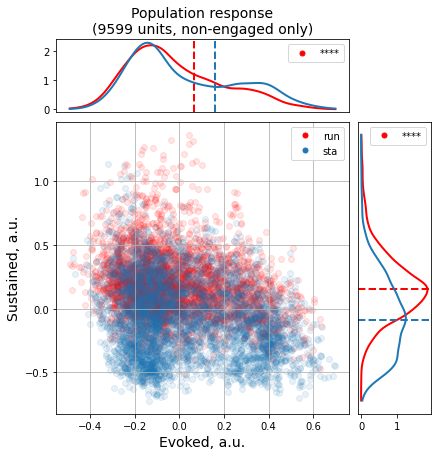

In [125]:
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(6.5, 6.5))
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/scatter_hist.html
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4), left=0.1, right=0.9, \
                      bottom=0.1, top=0.9, wspace=0.05, hspace=0.05)

idxs_all = [idxs_non_run_bU_ev, idxs_non_sta_bU_ev]  # can be also all TGT, idxs_tgt_ev
colors   = ['red', 'tab:blue']
alphas   = [0.1, 0.1]
labels   = ['run', 'sta']

# first - scatter plots
legend_elements = [
    Line2D([0], [0], marker='.', linestyle='None', color=colors[0], markersize=10, label=labels[0]),
    Line2D([0], [0], marker='.', linestyle='None', color=colors[1], markersize=10, label=labels[1]),
]

ax = fig.add_subplot(gs[1, 0])
for i, idxs in enumerate(idxs_all):
    ax.scatter(fit[idxs][:, 0], fit[idxs][:, 1], alpha=alphas[i], color=colors[i], label=labels[i])
#ax.scatter(fit[:, 0], fit[:, 1], alpha=0.1, c=np.log(speed[sound_events[:, 2].astype(np.int32)]), cmap='seismic')

# regression line for no stimulus
res = stats.linregress(fit[idxs_sil_bU_ev][:, 0], fit[idxs_sil_bU_ev][:, 1])
x = np.array([fit[idxs_sil_bU_ev][:, 0].min(), 1])
#ax.plot(x, res.intercept + res.slope*x, color='tab:blue', ls='--', lw=2)

ax.set_xlabel('Evoked, a.u.', fontsize=14)
ax.set_ylabel('Sustained, a.u.', fontsize=14)
ax.legend(handles=legend_elements)
ax.grid()


# second - evoked histograms
x = np.linspace(fit[:, 0].min(), fit[:, 0].max(), 100)

idxs1 = np.intersect1d(idxs_bgr_ev, idxs_non_run_bU_ev)
idxs2 = np.intersect1d(idxs_bgr_ev, idxs_non_sta_bU_ev)
idxs_bgr_only = [idxs1, idxs2]
p_val = stats.mannwhitneyu(fit[idxs1][:, 0], fit[idxs2][:, 0]).pvalue
legend_elements = [
    Line2D([0], [0], marker='.', linestyle='None', color=colors[0], markersize=10, label='%s' % pval2text(p_val)),
]

ax = fig.add_subplot(gs[0, 0])
for i, idxs in enumerate(idxs_all):
    density = stats.kde.gaussian_kde(fit[idxs][:, 0])
    ax.plot(x, density(x), color=colors[i], lw=2)
    ax.axvline(np.median(fit[idxs_bgr_only[i]][:, 0]), ls='--', color=colors[i], lw=2)
ax.set_xticks([])
ax.legend(handles=legend_elements)
ax.set_title('Population response\n(%d units, non-engaged only)' % len(unit_mx_ev), fontsize=14)

# third - sustained histograms
y = np.linspace(fit[:, 1].min(), fit[:, 1].max(), 100)

p_val = stats.mannwhitneyu(fit[idxs_bgr_ev][:, 1], fit[idxs_suc_ev][:, 1]).pvalue
legend_elements = [
    Line2D([0], [0], marker='.', linestyle='None', color=colors[0], markersize=10, label='%s' % pval2text(p_val)),
]

ax = fig.add_subplot(gs[1, 1])
for i, idxs in enumerate(idxs_all):
    density = stats.kde.gaussian_kde(fit[idxs][:, 1])
    ax.plot(density(y), y, color=colors[i], lw=2)
    ax.axhline(np.median(fit[idxs][:, 1]), ls='--', color=colors[i], lw=2)
ax.legend(handles=legend_elements)
ax.set_yticks([])

fig.tight_layout()
fig.savefig(os.path.join(rep_path, '%s_EV_SU_run_sta_map.png' % session[-19:-6]), dpi=300)

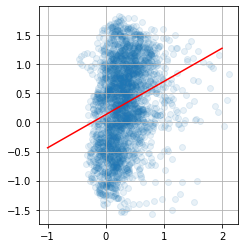

In [186]:
fig, ax = plt.subplots(1, 1)

var_A = fit[idxs_sil_bU_ev][:, 0]
var_B = fit[idxs_sil_bU_ev][:, 1]

ax.scatter(var_A, var_B, alpha=0.1)

# regression line for no stimulus
res = stats.linregress(var_A, var_B)
x = np.array([-1, 2])
ax.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
ax.set_aspect('equal')
ax.grid()

In [187]:
res

LinregressResult(slope=0.5705424206530091, intercept=0.13515638162290147, rvalue=0.24923814168692018, pvalue=2.3524744036413486e-37, stderr=0.04395300783655158, intercept_stderr=0.01956979931557083)

## Cross-session

In [33]:
resp_mx = np.zeros([len(all_selected), 7])  # animal, ev_bgr, ev_tgt, su_bgr, su_tgt, number of units, rel. performance
animal_ids = {'009266': 1, '009265': 2, '57': 3, '013829': 4}

for i, session in enumerate(all_selected):
    animal   = session.split('_')[0]
    session_path = os.path.join(source, animal, session)
    #nmap_file  = os.path.join(session_path, 'analysis', 'nMAP_EV_SU.h5')
    #if animal == '013829':
    nmap_file = os.path.join(session_path, 'analysis', 'nMAP_EV_SU_noconv.h5')
    #nmap_file = os.path.join(session_path, 'analysis', 'nMAP_EV_SU_with_PSTH.h5')
        
    meta_file  = os.path.join(session_path, 'meta.h5')

    with h5py.File(meta_file, 'r') as f:
        trials = np.array(f['processed']['trial_idxs'])
        sound_events = np.array(f['processed']['sound_events'])
        tgt_mx = np.array(f['processed']['target_matrix'])
    with h5py.File(nmap_file, 'r') as f:
        response_manifold = np.array(f['response_manifold'])
        #unit_mx_ev = np.array(f['unit_mx_ev'])
        #unit_mx_ev = np.array(f['unit_mx_proc_ev'])
    
    tr_succ = trials[trials[:, 5] == 1]
    performance = len(tr_succ) / (len(trials))
    
    # compute event indices
    idxs_bgr_ev = np.where(sound_events[:, 1] == 1)[0]
    idxs_sil_ev = np.where(sound_events[:, 1] == 0)[0]
    idxs_tgt_ev = np.where(sound_events[:, 1] == 2)[0]
    idxs_noi_ev = np.where(sound_events[:, 1] == -1)[0]

    idxs_suc_ev = []
    for tgt_rec in tgt_mx[tgt_mx[:, 4] == 1]:
        idxs_suc_ev += list(np.arange(tgt_rec[0], tgt_rec[1] + 1))
    idxs_suc_ev = np.array(idxs_suc_ev)
    
    resp_mx[i] = np.array([
        animal_ids[animal],
        response_manifold[idxs_bgr_ev][:, 0].mean(),
        response_manifold[idxs_suc_ev][:, 0].mean(),
        response_manifold[idxs_bgr_ev][:, 1].mean(),
        response_manifold[idxs_suc_ev][:, 1].mean(),
        30,
        performance
    ])

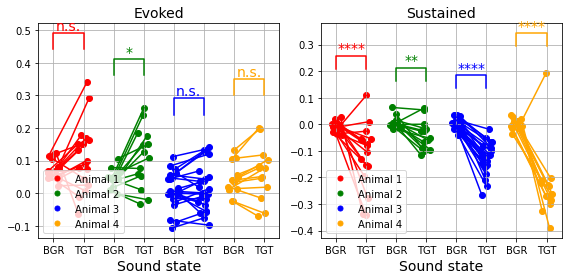

In [35]:
# filter by unit number
resp_mx_filt = resp_mx[resp_mx[:, 5] > 8]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

titles = ['Evoked', 'Sustained']
colors = ['red', 'green', 'blue', 'orange']

n_data = len(animal_ids)
for j, ax in enumerate(axes):
    for i, animal_id in enumerate(animal_ids.values()):
        metric = resp_mx_filt[resp_mx_filt[:, 0] == animal_id][:, 2*j+1:2*j+3]
        
        x_vals_AL = (2*i + 1)*np.ones(len(metric)) + (np.random.rand(len(metric)) - 0.5)*0.4
        x_vals_PH = (2*i + 2)*np.ones(len(metric)) + (np.random.rand(len(metric)) - 0.5)*0.4
        ax.scatter(x_vals_AL, metric[:, 0], color=colors[i])
        ax.scatter(x_vals_PH, metric[:, 1], color=colors[i])
        for k, record in enumerate(metric):
            ax.plot([x_vals_AL[k], x_vals_PH[k]], [metric[k][0], metric[k][1]], color=colors[i])

        # stats
        _, pval = stats.mannwhitneyu(metric[:, 0], metric[:, 1])
        x1, x2 = 2*i + 1, 2*i + 2
        y, h = max(map(max, metric)) + 0.1, 0.05

        ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=colors[i])
        ax.text((x1+x2)*.5, y+h, pval2text(pval), ha='center', va='bottom', color=colors[i], fontsize=14)

for i, ax in enumerate(axes):
    ax.set_title(titles[i], fontsize=14)
    ax.set_xlim(0.5, n_data*2 + 0.5)
    #if i < 2:
    #    ax.set_ylim(0.4, 1.8)
    ax.set_xticks(np.arange(2*n_data) + 1)
    ax.set_xticklabels(['BGR', 'TGT', 'BGR', 'TGT', 'BGR', 'TGT', 'BGR', 'TGT'])
    ax.set_xlabel('Sound state', fontsize=14)
    ax.grid()
    
legend_elements = [
    Line2D([0], [0], marker='.', linestyle='None', color=colors[0], markersize=10, label='Animal 1'),
    Line2D([0], [0], marker='.', linestyle='None', color=colors[1], markersize=10, label='Animal 2'),
    Line2D([0], [0], marker='.', linestyle='None', color=colors[2], markersize=10, label='Animal 3'),
    Line2D([0], [0], marker='.', linestyle='None', color=colors[3], markersize=10, label='Animal 4')
]
axes[0].legend(handles=legend_elements, loc='lower left')
axes[1].legend(handles=legend_elements, loc='lower left')

fig.tight_layout()
fig.savefig(os.path.join(rep_path, 'EV_SU_cross-session.png'), dpi=300)

### Correlation of sustained with performance

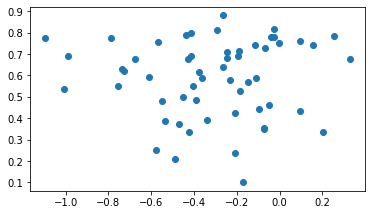

In [42]:
fig, ax = plt.subplots(1, 1)
ax.scatter(resp_mx[:, 4] - resp_mx[:, 3], resp_mx[:, 6])
ax.set_aspect('equal')

In [110]:
cn_count = 64
channels = np.arange(cn_count)
kcoords = np.zeros(cn_count)
for i in range(4):
    kcoords[32 + i*8:32 + (i+1)*8] = i+1

# probes configurations
xc, yc = np.zeros(cn_count), np.zeros(cn_count)

# A1 probe is 1 shank, -5mm ML, Y-spacing is 35um
xc[0:32] = -5000
yc[0:32] = np.array([35*i for i in range(32)])

# PPC probe is 4 shank, 3mm ML, V-shape
for i in range(4):
    xc[32 + i*8:32 + (i+1)*8] = -4000 + np.array([i*200 + 3*j for j in range(8)])
    yc[32 + i*8:32 + (i+1)*8] = np.abs(np.array([20*j for j in range(8)]) - 20*4)

probe = {
    'chanMap': channels,
    'xc': xc,
    'yc': yc,
    'kcoords': kcoords,
    'n_chan': cn_count
}

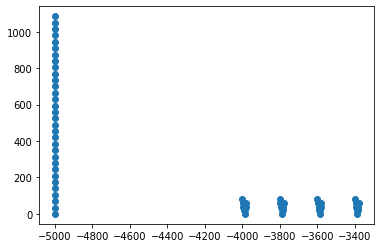

In [109]:
plt.scatter(xc, yc)

In [ ]:
ops, st, clu, tF, Wall, similar_templates, is_ref, est_contam_rate, kept_spikes = run_kilosort(settings=settings, probe=probe, save_preprocessed_copy=True)